Configuring LaTeX ...
$\newcommand{\dd}{\mbox{d}}$
$\newcommand{\A}{\mathcal{A}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\KL}{\mbox{KL}}$
$\newcommand{\Q}{\mathcal{Q}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\X}{\mathcal{X}}$
$\newcommand{\Y}{\mathcal{Y}}$

# TODO:

* Finish implementation of EnKF with smoothing for simulation=1
* Finish implementation of KF with smoothing
* Finish implementation of PF (with smoothing?)
* For EM algorithm, write a generic function (EM-Loss) that computes $\log(p(u, y|\theta))$ for a single $u$, or more generally, $\E_{u|y, \theta^{old}}[\log(p(u, y|\theta))]$ with MC samples (Note: Its relationship with $\log p(y|\theta)$ is unclear. It's part of the ELBO.
* After constructing this function, call `loss.backprop()` w.r.t. $\theta$ to get $\E_{u|y, \theta^{old}}[\nabla_\theta \log(p(u, y|\theta))]$. It is equal to $\nabla_\theta \log p(y|\theta)$ if both are evaluated at $\theta^{old}$. It's known as the Fisher's Identity. https://www.almoststochastic.com/2014/06/fishers-identity.html. Then do a gradient step. Can compare this with the gradient from Diff-EnKF.
* Moreover, can do multiple gradient steps within a single $\theta^{old}$. That's more like a traditional EM, e.g., EM-EnKS.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [ ]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
%load_ext autotime
%matplotlib inline

time: 1.51 ms (started: 2021-04-09 18:59:54 +00:00)


In [ ]:
import utils
from core_training import train_loop_diff, train_loop_em
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)

from utils import Timer
import copy
import math
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cpu
time: 7.47 s (started: 2021-04-09 19:02:13 +00:00)


# 3. Lorenz - Two scale

In [ ]:
class Lorenz96_FS(nn.Module):
  def __init__(self, param, xx_dim=36, xy_dim=10):
    super().__init__()
    self.param = nn.Parameter(param)
    
    self.xx_dim = xx_dim
    self.xy_dim = xy_dim
    self.x_dim = xx_dim * (xy_dim + 1)

    self.indices_x = torch.tensor([i for i in range(xx_dim)], dtype=torch.long)
    self.indices_x_p1 = torch.tensor([(i+1)%self.xx_dim for i in range(xx_dim)], dtype=torch.long)
    self.indices_x_m2 = torch.tensor([(i-2)%self.xx_dim for i in range(xx_dim)], dtype=torch.long)
    self.indices_x_m1 = torch.tensor([(i-1)%self.xx_dim for i in range(xx_dim)], dtype=torch.long)
    self.indices_y_p1 = torch.tensor([(i+1)%self.xy_dim for i in range(xy_dim)], dtype=torch.long)
    self.indices_y_p2 = torch.tensor([(i+2)%self.xy_dim for i in range(xy_dim)], dtype=torch.long)
    self.indices_y_m1 = torch.tensor([(i-1)%self.xy_dim for i in range(xy_dim)], dtype=torch.long)
  
  def forward(self, t, u):
    # (*bs * x_dim) -> (*bs * x_dim)
    F, h, c, b = self.param
    to_cat = []
    u_y = u[..., self.xx_dim:].reshape(-1, self.xx_dim, self.xy_dim) # (*bs, xx_dim, xy_dim)
    to_cat.append((u.index_select(-1, self.indices_x_p1) - u.index_select(-1, self.indices_x_m2)) * u.index_select(-1, self.indices_x_m1) - u[..., :self.xx_dim] + F - h * c * u_y.mean(dim=-1))
    to_cat.append(c * (-b * u_y.index_select(-1, self.indices_y_p1) * (u_y.index_select(-1, self.indices_y_p2) - u_y.index_select(-1, self.indices_y_m1)) - u_y + h / self.xy_dim * u[..., :self.xx_dim].unsqueeze(-1)).view(-1, self.xx_dim * self.xy_dim))
    out = torch.cat(to_cat, dim=-1)
    return out.to(device)
o = Lorenz96_FS(param=torch.tensor([10., 1., 10., 10.]))
# o.f(0,torch.randn(396))

time: 33.3 ms (started: 2021-03-18 02:50:47 +00:00)


In [ ]:
a = torch.eye(3).expand(2, 3, 3)
b = torch.cholesky_inverse(a)
print(b)

tensor([[[1., 0., -0.],
         [0., 1., -0.],
         [-0., -0., 1.]],

        [[1., 0., -0.],
         [0., 1., -0.],
         [-0., -0., 1.]]])
time: 7.07 ms (started: 2021-03-18 09:16:04 +00:00)


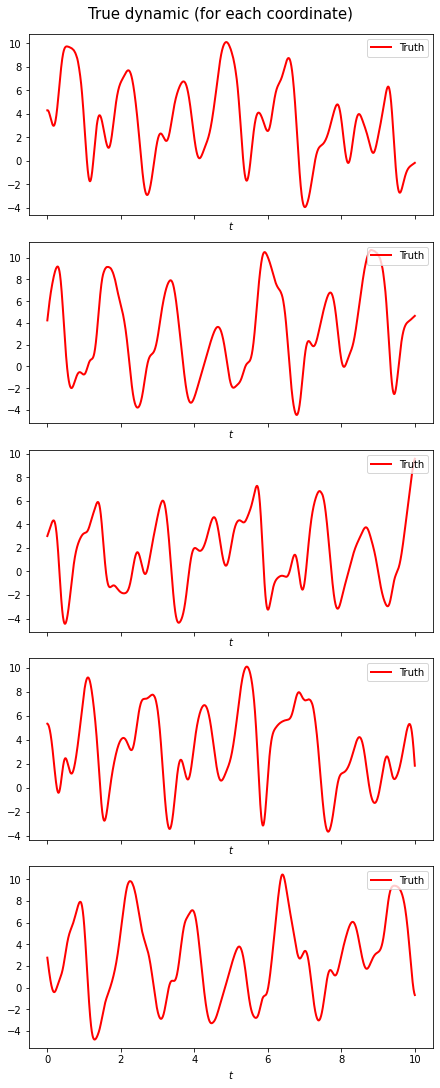

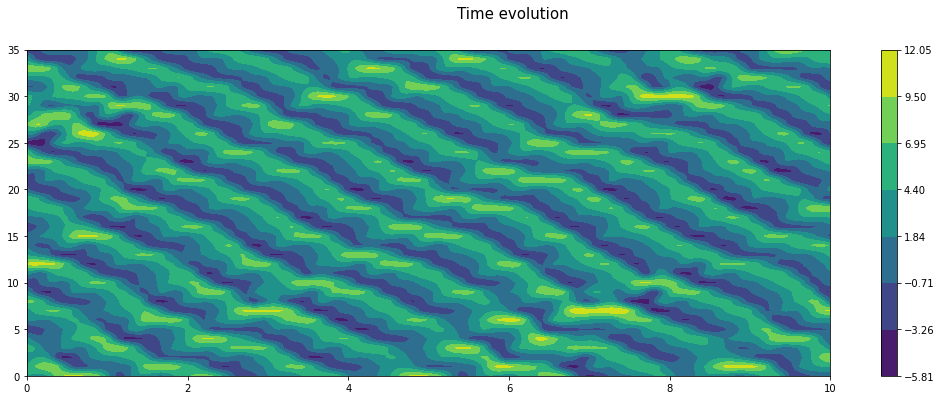

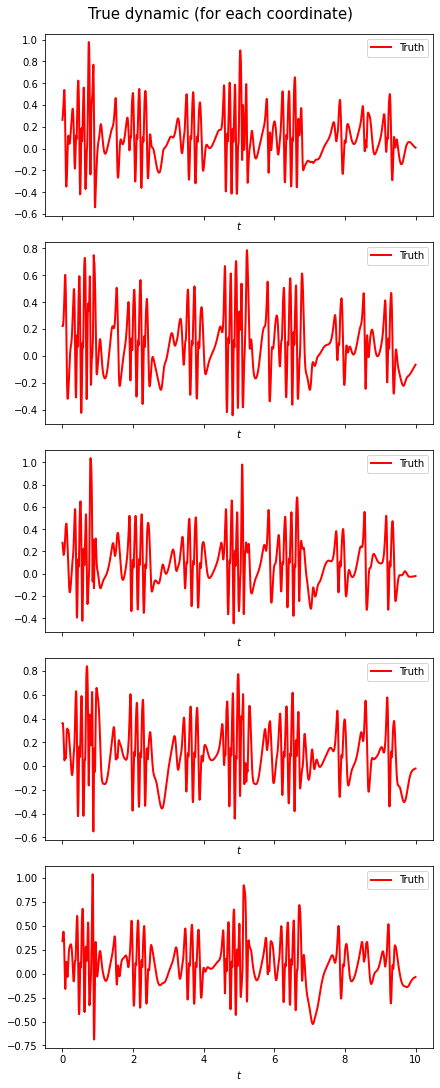

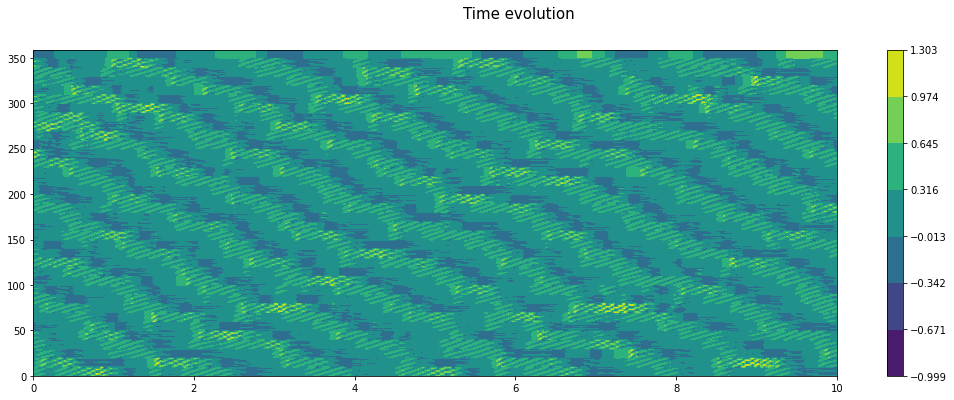

time: 13.5 s (started: 2021-03-18 02:58:55 +00:00)


In [ ]:
xx_dim = 36
xy_dim = 10
x_dim = xx_dim * (xy_dim + 1)
true_param = torch.tensor([10., 1., 10., 10.])
true_ode_func = Lorenz96_FS(true_param, xx_dim, xy_dim).to(device)

with torch.no_grad():
  xx_cov = 25 * torch.eye(xx_dim)
  xy_cov = 0.25 * torch.eye(xx_dim * xy_dim)
  cov = torch.block_diag(xx_cov, xy_cov).to(device)
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim), covariance_matrix=cov).sample().to(device) # <-
  out_warmup = odeint(true_ode_func, u0_warmup, torch.tensor([0., 40.], device=device), method='rk4', options=dict(step_size=0.005))
  u0 = out_warmup[-1].repeat(1)  # (*bs, x_dim)

t0 = 0.
t_obs_step = 0.01
t_obs_end = 10.
t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)


model_Q_true = None #0.01*torch.eye(x_dim, device=device)

# indices = [i for i in range(x_dim)]
# # indices = [3 * i for i in range(14)] + [3 * i + 1 for i in range(13)]
# y_dim = len(indices)
# H_true = torch.eye(x_dim)[indices]
# true_obs_func = NNModel.Linear(x_dim, y_dim, H=H_true).to(device)

def true_obs_func(X):
  # N * x_dim -> N * obs_dim
  bs = X.shape[:-1]
  to_cat = []
  to_cat.append(X[..., :xx_dim])
  Y_bar = X[..., xx_dim:].reshape(*bs, xx_dim, xy_dim).mean(dim=-1)
  to_cat.append(Y_bar)
  to_cat.append(X[..., :xx_dim]**2)
  to_cat.append(X[..., :xx_dim] * Y_bar)
  # to_cat.append(((X[:, xx_dim:].reshape(-1, xy_dim))**2).mean(dim=1).view(-1, xx_dim))
  return torch.cat(to_cat, dim=-1)

y_dim = true_obs_func(u0).shape[-1]
noise_R_true = 0.01 * torch.eye(y_dim, device=device)

with torch.no_grad():
  out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                device=device, ode_method='rk4', ode_options=dict(step_size=0.005), adjoint=False, save_intermediate_step=True, t0=0., time_varying_obs=False)

utils.plot_dynamic(t_intermediate, out_intermediate[:, :xx_dim], t_obs=None, y_obs=None, fig_num_limit=5, text="obs", contour_plot=True)
utils.plot_dynamic(t_intermediate, out_intermediate[:, xx_dim:], t_obs=None, y_obs=None, fig_num_limit=5, text="obs", contour_plot=True)
# y_obs = y_obs.repeat(1,1)
# y_obs = y_obs.reshape(-1, 16, y_dim)
# print(out_intermediate.shape)

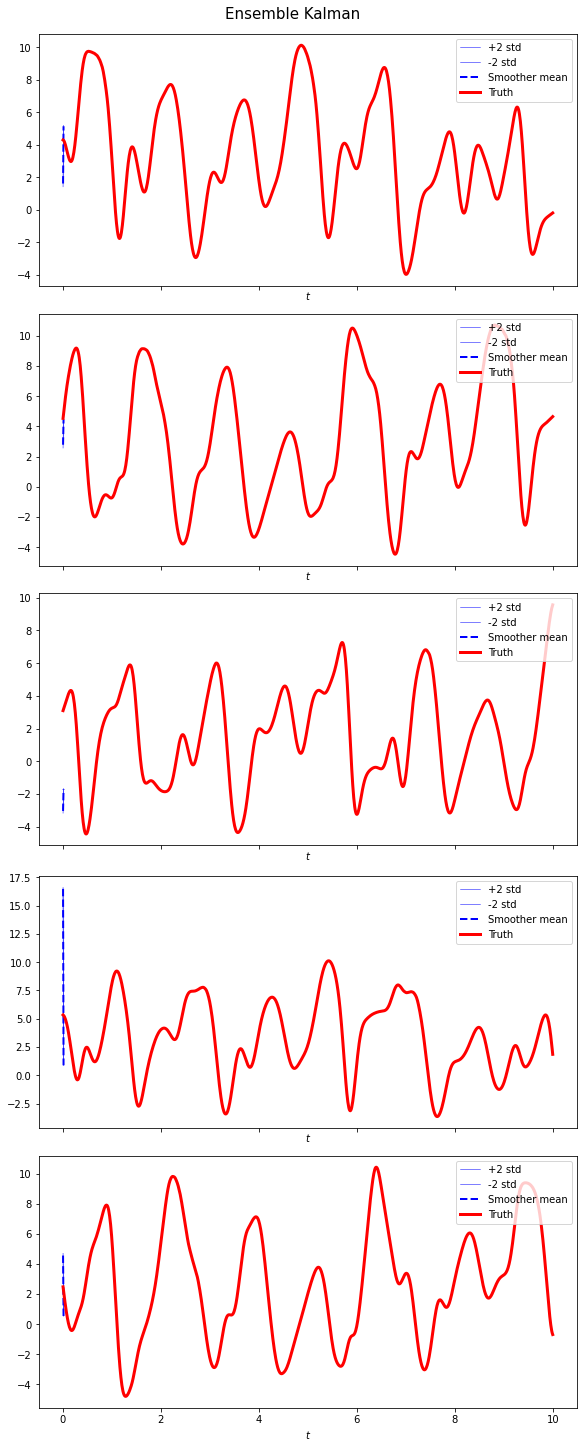

None


AttributeError: ignored

time: 45.5 s (started: 2021-03-18 02:59:12 +00:00)


In [ ]:
# test_ode_func = Lorenz96(F=8., x_dim=x_dim).to(device)
# true_param = torch.tensor([8., 0., 0., -1., 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.])
# test_ode_func = Lorenz96_param(param=true_param, x_dim=x_dim).to(device)
init_m = nn.Parameter(torch.zeros(x_dim, device=device))
init_C_param = cov
X_track, X_intermediate, neg_log_likelihood = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs, N_ensem=200, init_m=init_m, init_C_param=init_C_param, model_Q_param=model_Q_true, noise_R_param=noise_R_true, device=device, ode_method='rk4', 
                                          ode_options=dict(step_size=0.005),adjoint=True, init_C_type="full",
                                           model_Q_type="full", noise_R_type="full", save_intermediate_step=False, smooth_lag=0, t0=t0, 
                                           var_inflation=None, localization_radius=100, compute_likelihood=False, time_varying_obs=False, simulation_type=0)
utils.plot_filter(t_obs, out, X_track, plot_all=False, fig_num_limit=5)
# print(init_m.requires_grad)
print(neg_log_likelihood)
neg_log_likelihood.sum().backward()
# print(init_m.grad)
print(true_ode_func.param.grad)

In [ ]:
print(X_track)

tensor([[[  1.5899,   2.6662,  -3.1518,  ...,   0.8105,   1.1655,  -0.7667],
         [  1.6367,   2.7109,  -3.1082,  ...,   0.5680,   1.3094,  -0.9168],
         [  1.5001,   2.9832,  -2.9668,  ...,   0.4292,   0.5898,  -0.7632],
         ...,
         [  1.7456,   2.7212,  -2.9605,  ...,   0.4466,   0.3476,  -0.3235],
         [  1.7796,   3.0121,  -3.0491,  ...,  -0.2162,   0.8462,  -0.6714],
         [  1.5031,   2.9074,  -2.9833,  ...,  -0.2143,   0.5089,  -0.3399]],

        [[  5.1309,   4.4746,  -1.7190,  ..., -26.7318,  23.3953,  42.2351],
         [  5.1019,   4.4740,  -1.7407,  ..., -26.9978,  22.7112,  42.1273],
         [  5.0939,   4.4523,  -1.6669,  ..., -27.0269,  22.9284,  41.8339],
         ...,
         [  5.1429,   4.4405,  -1.6777,  ..., -27.3699,  22.8779,  42.2985],
         [  5.1906,   4.4836,  -1.6909,  ..., -27.8271,  23.2037,  42.1747],
         [  5.1212,   4.4545,  -1.6667,  ..., -27.8282,  22.6423,  41.9476]],

        [[     nan,      nan,      nan,  ...